In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import U3Gate
from qiskit.extensions import UnitaryGate
# Important packages:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute, Aer
import numpy as np
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import random_unitary
from qiskit.extensions import UnitaryGate

In [2]:
def decimalToBinary(n,N):
    bin1=bin(n).replace("0b", "")
    bin2='0'*(N-len(bin1))+bin1
    return bin2

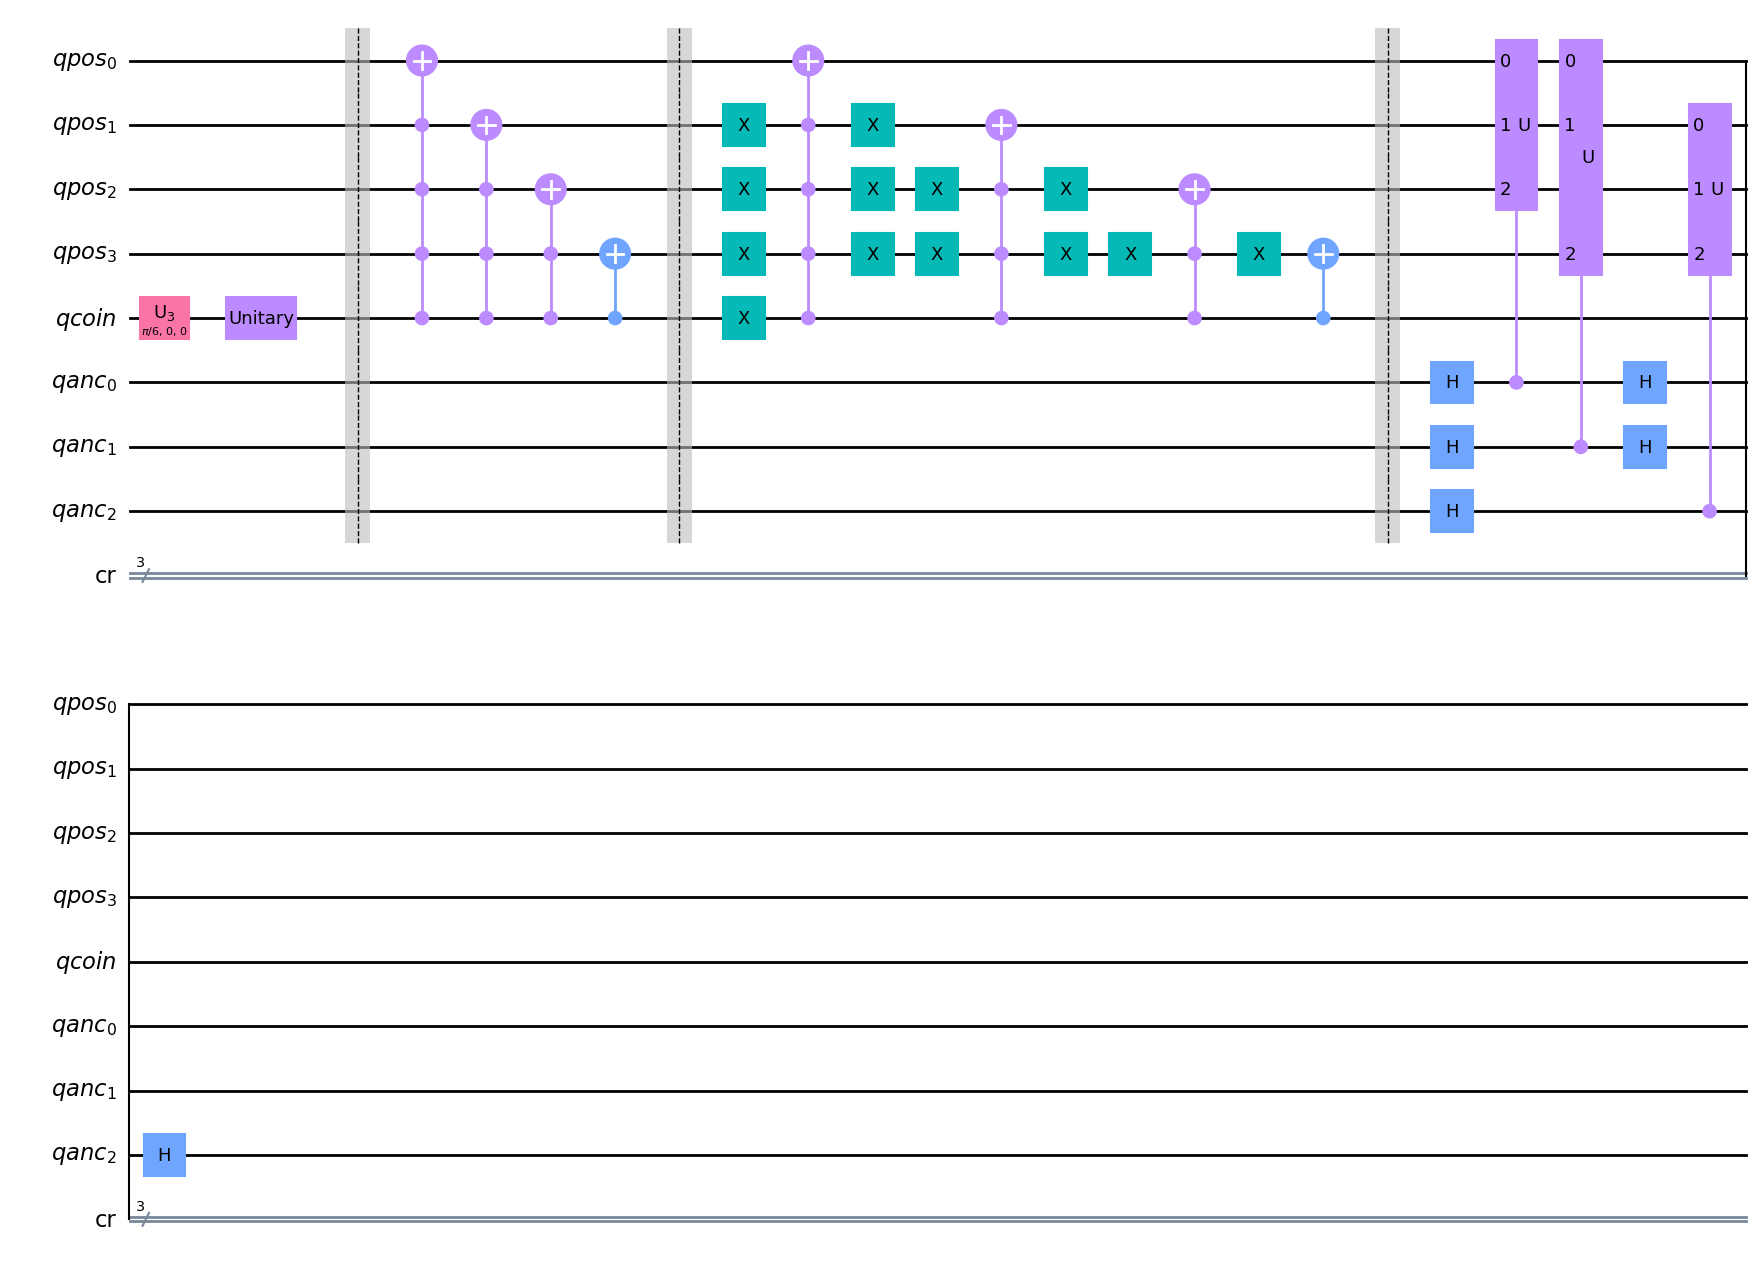

In [3]:
# Define the message and ensure it has an even number of bits
original_message = "00110011010101010101010011000111"
if len(original_message) % 2 != 0:
    original_message += "0"
    
steps = 2  # Number of steps, corresponding to the length of the message
n = 4  # Number of quantum positions

qanc = QuantumRegister(3, 'qanc')
qpos = QuantumRegister(n, 'qpos')
qcoin = QuantumRegister(1, 'qcoin')
cpos = ClassicalRegister(3, 'cr')
circuit = QuantumCircuit(qpos, qcoin, cpos, qanc)
    

initial_angle = np.arcsin(np.sin(np.pi/6))  # Adjust the angle θ as needed
initial_state = U3Gate(initial_angle, 0, 0)
circuit.append(initial_state, [qcoin])


# Define the coin operators based on the description
def coin_operator_C1():
    return np.array([[np.cos(np.pi/8), np.sin(np.pi/8)],
                     [np.sin(np.pi/8), -np.cos(np.pi/8)]])

def coin_operator_C2():
    return np.array([[np.cos(np.pi/4), np.sin(np.pi/4)],
                     [np.sin(np.pi/4), -np.cos(np.pi/4)]])

def coin_operator_C3():
    return np.array([[np.cos(np.pi/3), np.sin(np.pi/3)],
                     [np.sin(np.pi/3), -np.cos(np.pi/3)]])

def coin_operator_C4():
    return np.array([[np.cos(3*np.pi/7), np.sin(3*np.pi/7)],
                     [np.sin(3*np.pi/7), -np.cos(3*np.pi/7)]])

def apply_coin_operator(circuit, qcoin, message_bits):
    if message_bits == "00":
        circuit.unitary(coin_operator_C1(), [qcoin])
    elif message_bits == "01":
        circuit.unitary(coin_operator_C2(), [qcoin])
    elif message_bits == "10":
        circuit.unitary(coin_operator_C3(), [qcoin])
    elif message_bits == "11":
        circuit.unitary(coin_operator_C4(), [qcoin])

def counts_to_prob_1d(counts, n):
    # Convert histogram counts to probability vector of size 1 x 2^n
    states = list(counts.keys())
    state_counts = list(counts.values())
    nshots = sum(state_counts)
    
    # Create array of probability values in reverse order
    probabilities = np.zeros(2 ** n)
    for i, state in enumerate(states):
        index = int(state, 2)
        probabilities[index] = state_counts[i]
    
    probabilities /= nshots
    return probabilities




def increment_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        circuit.mcx([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')

def decrement_gate(circuit, qpos, qcoin):
    n = len(qpos)
    circuit.x(qcoin[0])
    for i in range(n):
        if i + 1 < n:
            circuit.x(qpos[i + 1:])
        circuit.mcx([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')
        if i + 1 < n:
            circuit.x(qpos[i + 1:])

def step(circuit, qpos, qcoin, message_bits):
    apply_coin_operator(circuit, qcoin, message_bits)
    circuit.barrier()
    increment_gate(circuit, qpos, qcoin)
    circuit.barrier()
    decrement_gate(circuit, qpos, qcoin)
    circuit.barrier()
    
def build_circ(_circuit, _register, _params, _n_qubits, _barrier = False):
    """
    Implements a parametrized quantum circuit in the _register chosen.
    """
    for index in range(_n_qubits):
        _circuit.h(index)
        _circuit.rx(_params[index], _register[index])

    # the CNOT Layer
    for k in range(_n_qubits - 1):
        _circuit.cx(_register[k], _register[k+1])

    if _barrier:
        _circuit.barrier()

    return _circuit
 
nqubits = 3
nb_params = nqubits

q = QuantumRegister(nqubits, 'qubit')
circ_psi = QuantumCircuit(q)
p = QuantumRegister(3, 'qubit')
nb_params = 3
circ_phi = QuantumCircuit(p)

params_phi = [el for el in range( nb_params, 2*nb_params)]

circ_phi = build_circ(circ_phi, q, params_phi, 3, _barrier = False)
    
U_phi_dagger = circ_phi.to_gate(label = "U_phi^dagger").inverse()
definition = [q[index] for index in range(nqubits)]
U_circ = circ_psi.copy()
U_circ.append(U_phi_dagger, definition)

      
U_controlled_gate = (U_circ.to_gate(label = "U")).control(1)
definition1 = [qanc[0]] + [qpos[0], qpos[1], qpos[2]]
definition2 = [qanc[1]] + [qpos[0], qpos[1], qpos[3]]
definition3 = [qanc[2]] + [qpos[1], qpos[2], qpos[3]]
evaluate_complex_part = False
    
def run_quantum_coin_walk(message, steps):
    simulator = Aer.get_backend('statevector_simulator')

    for i in range(len(message) // 2):
        message_bits = message[i * 2:i * 2 + 2]  # Extract the message bits for this step
        step(circuit, qpos, qcoin, message_bits)
        
    for i in range(3):
        circuit.h(qanc[i])
        
    # Apply controlled unitary matrix operations
    circuit.append(U_controlled_gate, definition1)
    circuit.append(U_controlled_gate, definition2)
    circuit.append(U_controlled_gate, definition3)
    
   
    for i in range(3):
        circuit.h(qanc[i])
        
       # Measure qanc into cpos
    #circuit.measure(qanc, cpos)

    #job = execute(circuit, simulator, shots=1000)
    #result = job.result()
    #counts = result.get_counts(circuit)
    return circuit

circ=run_quantum_coin_walk('11', 1)
circ.draw('mpl')



In [1]:
from skrmt.ensemble.circular_ensemble import CircularEnsemble
import numpy as np
import random
def generate_gue_matrix(n):
    # Generate a random complex matrix
    real_part = np.random.randn(n, n)
    imag_part = np.random.randn(n, n)
    random_matrix = real_part + 1j * imag_part
    
    # Perform QR decomposition to obtain a unitary matrix
    q, r = np.linalg.qr(random_matrix)
    unitary_matrix = q
    
    return unitary_matrix

# Define parameters
n = 6
steps = 2
lqpos = 5
lqcoin = 1
lqanc = 6

# Generate random unitary matrices from the Gaussian Ensemble
list_unitary = [generate_gue_matrix(4) for _ in range(lqanc)]
for i, matrix in enumerate(list_unitary):
    if not np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T):
        print(f"Matrix {i} is not unitary!")
# Randomize target_qubit
target_qubit = [random.choice(range(0, lqpos)) for _ in range(n)]

In [4]:
from skrmt.ensemble import GaussianEnsemble
import numpy as np
import random

list_unitary = [GaussianEnsemble(beta=4, n=4).matrix for _ in range(lqanc)]
for i, matrix in enumerate(list_unitary):
    if not np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T):
        print(f"Matrix {i} is not unitary!")
# Randomize target_qubit
target_qubit = [random.choice(range(0, lqpos)) for _ in range(n)]

Matrix 0 is not unitary!
Matrix 1 is not unitary!
Matrix 2 is not unitary!
Matrix 3 is not unitary!
Matrix 4 is not unitary!
Matrix 5 is not unitary!


In [44]:
original_message1='01100010110101001'
original_message2='11100010110101001'
original_message3='00100010110101001'
original_message4='1100010110101001'
original_message5='011000101101010010'



def circ_quantum_hash(message, steps):
    
    qpos = QuantumRegister(lqpos, 'qpos')
    qcoin = QuantumRegister(1, 'qcoin')
    qanc = QuantumRegister (lqanc, 'qanc')
    cpos = ClassicalRegister(lqanc, 'cr')
    circuit = QuantumCircuit(qpos, qcoin, cpos, qanc)
    
    initial_angle = np.arcsin(np.sin(np.pi/6))  # Adjust the angle θ as needed
    initial_state = U3Gate(initial_angle, 0, 0)
    circuit.append(initial_state, [qcoin])
    
    
    for i in range(len(message) // 2):
        message_bits = message[i * 2:i * 2 + 2]  # Extract the message bits for this step
        step(circuit, qpos, qcoin, message_bits)
        
    for i in range(len(qanc)):
        circuit.h(qanc[i])
        
        haar_random_gate = UnitaryGate(list_unitary[i]) #Applying a single qubit random unitary gate
        qc = QuantumCircuit(1)
        qc.append(haar_random_gate, [0])

        custom = qc.to_gate().control(1) #adding a single control to it

        
        circuit.append(custom, [lqpos+lqcoin+i, target_qubit[i]])

        circuit.h(qanc[i])
        
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    psi_block2 = job.result().get_statevector(circuit, decimals=16)
    list1=[]
    list2=[]
    for j in range(len(psi_block2)):        
        list1.append(j)
        list2.append(abs(psi_block2[j]))

    nv= lqpos+lqanc+lqcoin
    probave2=list(abs(num**2) for num in list2)
    states = [decimalToBinary(i, nv) for i in range(2**nv)]
    possible_hash=[decimalToBinary(i, lqanc) for i in range(2**lqanc)]
    counts = dict(zip(states, probave2))
    hash_prob_list=[]
    for j in possible_hash:
        hash_prob=0.0
        for i in states:
            hash_state=i[lqcoin+lqpos:]
            if j==hash_state:
                hash_prob+=counts[i]
        hash_prob_list.append(hash_prob)
    
    hash_counts=dict(zip(possible_hash, hash_prob_list))
    hash_counts
    return hash_counts

def generate_hash_from_counts(hash_counts):
    # Concatenate the binary hash values corresponding to sorted hash counts
    sorted_counts = dict(sorted(hash_counts.items(), key=lambda item: item[1], reverse=True))
    hash_value = ''.join(sorted_counts.keys())
    print(hash_value)
    return hash_value

count=circ_quantum_hash(original_message1, n)
generate_hash_from_counts(count)
count=circ_quantum_hash(original_message2, n)
generate_hash_from_counts(count)
count=circ_quantum_hash(original_message3, n)
generate_hash_from_counts(count)
count=circ_quantum_hash(original_message4, n)
generate_hash_from_counts(count)
count=circ_quantum_hash(original_message5, n)
generate_hash_from_counts(count)

CircuitError: 'The amount of qubit(1)/clbit(0) arguments does not match the gate expectation (2).'

In [8]:




original_message='1111111111'
from skrmt.ensemble.circular_ensemble import CircularEnsemble
import numpy as np
import random
def generate_gue_matrix(n):
    # Generate a random complex matrix
    real_part = np.random.randn(n, n)
    imag_part = np.random.randn(n, n)
    random_matrix = real_part + 1j * imag_part
    
    # Perform QR decomposition to obtain a unitary matrix
    q, r = np.linalg.qr(random_matrix)
    unitary_matrix = q
    
    return unitary_matrix

# Define parameters
n = 5
steps = 2
lqpos = 5
lqcoin = 1
lqanc = 5

# Generate random unitary matrices from the Gaussian Ensemble
list_unitary = [generate_gue_matrix(8) for _ in range(lqanc)]
for i, matrix in enumerate(list_unitary):
    if not np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T):
        print(f"Matrix {i} is not unitary!")
# Randomize target_qubit
target_qubit = [random.choice(range(0, lqpos)) for _ in range(n)]

In [9]:
import collections

def circ_quantum_hash(message, steps):
    
    qpos = QuantumRegister(lqpos, 'qpos')
    qcoin = QuantumRegister(1, 'qcoin')
    qanc = QuantumRegister (lqanc, 'qanc')
    cpos = ClassicalRegister(lqanc, 'cr')
    circuit = QuantumCircuit(qpos, qcoin, cpos, qanc)
    
    initial_angle = np.arcsin(np.sin(np.pi/6))  # Adjust the angle θ as needed
    initial_state = U3Gate(initial_angle, 0, 0)
    circuit.append(initial_state, [qcoin])
    
    
    for i in range(len(message) // 2):
        message_bits = message[i * 2:i * 2 + 2]  # Extract the message bits for this step
        step(circuit, qpos, qcoin, message_bits)
        
    for i in range(len(qanc)):
        circuit.h(qanc[i])
        
        haar_random_gate = UnitaryGate(list_unitary[i]) #Applying a single qubit random unitary gate
        qc = QuantumCircuit(3)
        qc.append(haar_random_gate, [0,1,2])

        custom = qc.to_gate().control(1) #adding a single control to it

        
        circuit.append(custom, [lqpos+lqcoin+i, target_qubit[i], (target_qubit[i]+1)%n, (target_qubit[i]+2)%n])

        circuit.h(qanc[i])
        
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    psi_block2 = job.result().get_statevector(circuit, decimals=16)
    list1=[]
    list2=[]
    for j in range(len(psi_block2)):        
        list1.append(j)
        list2.append(abs(psi_block2[j]))

    nv= lqpos+lqanc+lqcoin
    probave2=list(abs(num**2) for num in list2)
    states = [decimalToBinary(i, nv) for i in range(2**nv)]
    possible_hash=[decimalToBinary(i, lqanc) for i in range(2**lqanc)]
    counts = dict(zip(states, probave2))
    hash_prob_list=[]
    for j in possible_hash:
        hash_prob=0.0
        for i in states:
            hash_state=i[lqcoin+lqpos:]
            if j==hash_state:
                hash_prob+=counts[i]
        hash_prob_list.append(hash_prob)
    
    hash_counts=dict(zip(possible_hash, hash_prob_list))
    hash_counts
    return hash_counts

def generate_hash_from_counts(hash_counts):
    # Concatenate the binary hash values corresponding to sorted hash counts
    sorted_counts = dict(sorted(hash_counts.items(), key=lambda item: item[1], reverse=True))
    hash_value = ''.join(sorted_counts.keys())
    return hash_value

def calculate_changed_bits(hash_value1, hash_value2):
    changed_bits = sum(bit1 != bit2 for bit1, bit2 in zip(hash_value1, hash_value2))
    added_zero_bits=0;
    added_zero_bits += max(0, len(hash_value1) - len(hash_value2))
    return changed_bits, added_zero_bits

def perform_diffusion_confusion_tests(N, message, n):
    original_counts = circ_quantum_hash(message, n)
    original_hash = generate_hash_from_counts(original_counts)
    BBN_list, AAN_list, TAB_list, PT_list, TN_list, PN_list = [], [], [], [], [], []

    for i in range(N):
        original_counts=circ_quantum_hash(message, n)
        original_hash = generate_hash_from_counts(original_counts)
        modified_message = modify_message_randomly(message)
        modified_counts=circ_quantum_hash(modified_message, n)
        modified_hash = generate_hash_from_counts(modified_counts)

        changed_bits, added_zero_bits = calculate_changed_bits(original_hash, modified_hash)

        BBN_list.append(changed_bits)
        AAN_list.append(added_zero_bits)
        TAB_list.append(changed_bits + added_zero_bits)

    # Step 5: Calculate mean values and variances
    BBN = sum(BBN_list) / N
    AAN = sum(AAN_list) / N
    T_mean = sum(TAB_list) / N
    P_mean = (T_mean / (len(original_hash))) * 100

    T_variance = sum((Ti - T_mean) ** 2 for Ti in TAB_list) / (N - 1)
    P_variance = sum(((Ti / (len(original_hash))) - P_mean) ** 2 for Ti in TAB_list) / (N - 1)


    BBN_list.append(BBN)
    AAN_list.append(AAN)
    TAB_list.append(T_mean)
    PT_list.append(P_mean)
    TN_list.append(T_variance)
    PN_list.append(P_variance)

    return BBN_list, AAN_list, TAB_list, PT_list, TN_list, PN_list

def modify_message_bitswise(message, bit_number):
    m_length=list(np.arange(len(message)))
    bits = random.sample(m_length, bit_number)
    list_message=list(message)
    for bit in bits:
        if list_message[bit] == '0':
            list_message[bit] = '1'
        else:
            list_message[bit] = '0'

    mod_message= ' '.join([str(elem) for elem in list_message])
    
    return mod_message

def list_to_ascii_method(int_list):
    ascii_chars = [chr(num) for num in int_list]
    return ''.join(ascii_chars)

def modify_message_randomly(message, unique_modified_messages):
    message_length = len(message)
    modified_message = ''.join(random.choice('01') for _ in range(message_length))

    while modified_message in unique_modified_messages:
        modified_message = ''.join(random.choice('01') for _ in range(message_length))

    unique_modified_messages.add(modified_message)
    return modified_message


def calculate_total_collisions(N, message, n):
    collision_count = 0
    unique_collisions = set()

    for i in range(N):
        original_counts = circ_quantum_hash(message, n)
        original_hash = generate_hash_from_counts(original_counts)
        # Call the function with the set as an argument
        unique_modified_messages = set()
        modified_message = modify_message_randomly(message, unique_modified_messages)
        modified_counts = circ_quantum_hash(modified_message, n)
        modified_hash = generate_hash_from_counts(modified_counts)

        if original_hash == modified_hash:
            if modified_message not in unique_collisions:
                print(modified_message)
                unique_collisions.add(modified_message)
                collision_count += 1

    return collision_count


N_values = [10]
N_collision_test = 1024



# for N in N_values:
    # BBN_list, AAN_list, TAB_list, PT_list, TN_list, PN_list = perform_diffusion_confusion_tests(N, original_message, n)

    # variance_TAB = np.var(TAB_list, ddof=0)
    # variance_PN = np.var(PT_list, ddof=0)
total_collision_count = calculate_total_collisions(N_collision_test, original_message, n)
collision_rate = total_collision_count / N_collision_test

    #print(f"N = {N}")
    #print("Mean BBN:", np.mean(BBN_list))
    #print("Mean AAN:", np.mean(AAN_list))
    #print("Mean TAB:", np.mean(TAB_list))
    #print("Mean PT (%):", np.mean(PT_list))
    #print("Variance TAB:", variance_TAB)
    #print("Variance PN:", variance_PN)
print(f"Total Collision Count: {total_collision_count}")
print(f"Collision Rate: {collision_rate:.4f}")


1111111111


KeyboardInterrupt: 

In [10]:
def hamming_distance(str1, str2):
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

def avalanche_effect(original_message, modified_message):
    original_counts = circ_quantum_hash(original_message, n)
    original_hash = generate_hash_from_counts(original_counts)
    modified_counts = circ_quantum_hash(modified_message, n)
    modified_hash = generate_hash_from_counts(modified_counts)
    
    
    distance = hamming_distance(original_hash, modified_hash)
    percentage_change = (distance / len(original_hash)) * 100
    
    return percentage_change



In [11]:
def modify_message_bitwise(message, bit_number, unique_modified_messages):
    m_length = list(np.arange(len(message)))
    
    while True:
        bits = random.sample(m_length, bit_number)
        list_message = list(message)

        for bit in bits:
            if list_message[bit] == '0':
                list_message[bit] = '1'
            else:
                list_message[bit] = '0'

        mod_message = ''.join(list_message)

        if mod_message not in unique_modified_messages:
            unique_modified_messages.add(mod_message)
            return mod_message

In [12]:
N_a = 10
list_percentages = []
original_message='1111011111'
unique_modified_messages = set()
for i in range(N_a):
    modified_message = modify_message_bitwise(original_message, 1, unique_modified_messages)
    print(modified_message)
    percentage_change=avalanche_effect(original_message, modified_message)
    list_percentages.append(percentage_change)

average_percentage_change = np.mean(list_percentages)
print(f"Average Avalanche Effect: {average_percentage_change:.2f}%")

1111001111
1011011111
1101011111
1111011110
1111111111
0111011111
1111011101
1111010111
1111011011
1110011111
Average Avalanche Effect: 13.12%


In [45]:
from skrmt.ensemble.circular_ensemble import CircularEnsemble
import numpy as np
import random

# Function to compute Hamming distance
def hamming_distance(str1, str2):
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

# Function to compute avalanche effect
def avalanche_effect(original_message, modified_message):
    original_counts = circ_quantum_hash(original_message, n)
    original_hash = generate_hash_from_counts(original_counts)
    modified_counts = circ_quantum_hash(modified_message, n)
    modified_hash = generate_hash_from_counts(modified_counts)
    
    distance = hamming_distance(original_hash, modified_hash)
    percentage_change = (distance / len(original_hash)) * 100
    
    return percentage_change

# Function to modify message bitwise
def modify_message_bitwise(message, bit_number, unique_modified_messages):
    m_length = list(np.arange(len(message)))
    
    while True:
        bits = random.sample(m_length, bit_number)
        list_message = list(message)

        for bit in bits:
            if list_message[bit] == '0':
                list_message[bit] = '1'
            else:
                list_message[bit] = '0'

        mod_message = ''.join(list_message)

        if mod_message not in unique_modified_messages:
            unique_modified_messages.add(mod_message)
            return mod_message

# Define the number of iterations
N = 1000

# List to store average avalanche effect percentages
avg_percentages = []

# Run the loop for N iterations
for i in range(N):
    n = 6
    lqanc = 6

    list_unitary = [CircularEnsemble(beta=1, n=2).matrix for _ in range(lqanc)]
    for i, matrix in enumerate(list_unitary):
        if not np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T):
            print(f"Matrix {i} is not unitary!")

    target_qubit = [random.choice(range(0, lqpos)) for _ in range(n)]

    N_a = 10
    list_percentages = []
    unique_modified_messages = set()
    original_message = '1111100000'
    for i in range(N_a):
        
        modified_message = modify_message_bitwise(original_message, 1, unique_modified_messages)
        percentage_change = avalanche_effect(original_message, modified_message)
        list_percentages.append(percentage_change)

    average_percentage_change = np.mean(list_percentages)
    avg_percentages.append(average_percentage_change)

# Calculate the overall average of avalanche effects
overall_average = np.mean(avg_percentages)
print(f"Overall Average Avalanche Effect: {overall_average:.2f}%")


011000011010011001011011110111001000110101110110111000001010001001110100111010111111111001110000011100001011100111010111111101111011111110110010010101010100010110110001011110110011011101111100100101100110101000011111100100101010101111101001100000001100000111101101101011010000101110100010000101000100000110100001001110100011001101101100010010010001010011001111000000000010000001000011
110111110101110110011000110100011010011001100111010111011011100101111111100110010101010110001000110011110000111000111101100100110001110010111110010100001010001001111010111001111011011100011111111100011110011101000111001011101111000101000110100011100000010011101000101101100001100010010000101110010001010010000100101010101001101011001100001111101100001110001101000011000000000001000010
01100001101001100101101111011100100011010111011011100000101000100111010011101011111111100111000001110000101110011101011111110111101111111011001001010101010001011011000101111011001101110111110010010110011010100001111110010010101010